**Title   : Credit Card Fraud Detection**
>*Author  : Clarissa Beatrice Kosasih*

# Information About the Dataset

This code uses dataset from https://www.kaggle.com/code/gurdittdadiala/creditcard-fraud-detection/input?select=fraudTest.csv

## Columns

1. index - Unique Identifier for each row
2. trans_date_trans_time - Transaction DateTime
3. cc_num - Credit Card Number of Customer
4. merchant - Merchant Name
5. category - Category of Merchant
6. amt - Amount of Transaction
7. first - First Name of Credit Card Holder
8. last - Last Name of Credit Card Holder
9. gender - Gender of Credit Card Holder
10. street - Street Address of Credit Card Holder
11. city - City of Credit Card Holder
12. state - State of Credit Card Holder
13. zip - Zip of Credit Card Holder
14. lat - Latitude Location of Credit Card Holder
15. long - Longitude Location of Credit Card Holder
16. city_pop - Credit Card Holder's City Population
17. job - Job of Credit Card Holder
18. dob - Date of Birth of Credit Card Holder
19. trans_num - Transaction Number
20. unix_time - UNIX Time of transaction
21. merch_lat - Latitude Location of Merchant
22. merch_long - Longitude Location of Merchant
23. is_fraud - Fraud Flag <--- Target Class

# Libraries & Read Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Projects/Credit Card Fraud Detection

/content/drive/MyDrive/Projects/Credit Card Fraud Detection


In [4]:
!ls

avg_amt_stats.csv    fraud_model.json  fraud_pipeline.pkl  scaler.pkl
fraud_detect_cc.csv  fraud_model.pkl   merchant_stats.csv


In [5]:
!pip install keras-tuner

In [6]:
!pip install shap

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Normal distribution test (bigger dataset)
from scipy.stats import anderson # anderson-darling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder

import tensorflow as tf
import keras_tuner as kt

# explanation of how each feature impacts the model's prediction
import shap

## Set Seed

In [8]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Read File

In [9]:
raw_data = pd.read_csv('fraud_detect_cc.csv')
raw_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

The dataset is already **clean**, so no further action is needed. It consists of 555,719 rows and 23 columns.

# Data Preprocessing

## Drop Duplicates

In [11]:
data = raw_data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

No duplicate are found.

## Drop ID Column

In [12]:
# Drop ID
data = data.drop(['Unnamed: 0'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

Columns with unique values may disrupt the model performance, so it will be dropped.

## Convert `trans_date_trans_time` & `dob` to Date Time

In [13]:
# Convert 'trans_date_trans_time' to date time
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Convert 'dob' to date time
data['dob'] = pd.to_datetime(data['dob'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

# Feature Engineering

## Transform `dob` to `age`

In [20]:
data['age'] = (data['trans_date_trans_time'].dt.year - data['dob'].dt.year).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

## Customer History Related

In [21]:
# Average transaction amount for each customer over the last 7 days
data['avg_amt_last_7d'] = data.groupby('cc_num')['amt'].transform(lambda x: x.rolling(7).mean())

data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,avg_amt_last_7d
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,52,NaN
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,30,NaN
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,50,NaN
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,33,NaN
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,65,NaN


In [22]:
data.isna().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


New missing values appear because there is no transaction history to calculate the average for some customers.

In [23]:
# Replace NA with 0
data['avg_amt_last_7d'] = data['avg_amt_last_7d'].fillna(0).astype('int64')
data.isna().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [24]:
avg_amt_stats = data[['cc_num', 'avg_amt_last_7d']].copy()
avg_amt_stats.to_csv('avg_amt_stats.csv')

## Merchant History

In [25]:
# how problematic the merchant is (high risk)
merchant_stats = data.groupby('merchant').agg(
    total_txn=('is_fraud', 'count'),
    total_fraud=('is_fraud', 'sum')
).reset_index()

merchant_stats['merchant_fraud_rate'] = merchant_stats['total_fraud'] / merchant_stats['total_txn']

# Merge to main dataset
data = data.merge(merchant_stats[['merchant', 'merchant_fraud_rate']], on='merchant', how='left')

In [26]:
merchant_stats[['merchant', 'merchant_fraud_rate']].to_csv('merchant_stats.csv')

## Transaction Behaviour

In [28]:
# 1. Hour of Transaction
data['hour'] = data['trans_date_trans_time'].dt.hour

# 2. Day of Week (Monday, Tuesday, etc)
data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

# EDA

In [30]:
# Separate categorical columns and numerical columns
cat_cols = data.select_dtypes(include = ['object', 'category']).columns

num_cols = data.select_dtypes(include = ['number']).columns

In [31]:
print(num_cols)
print(cat_cols)

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'avg_amt_last_7d',
       'merchant_fraud_rate', 'hour', 'day_of_week'],
      dtype='object')
Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'trans_num'],
      dtype='object')


## Boxplot

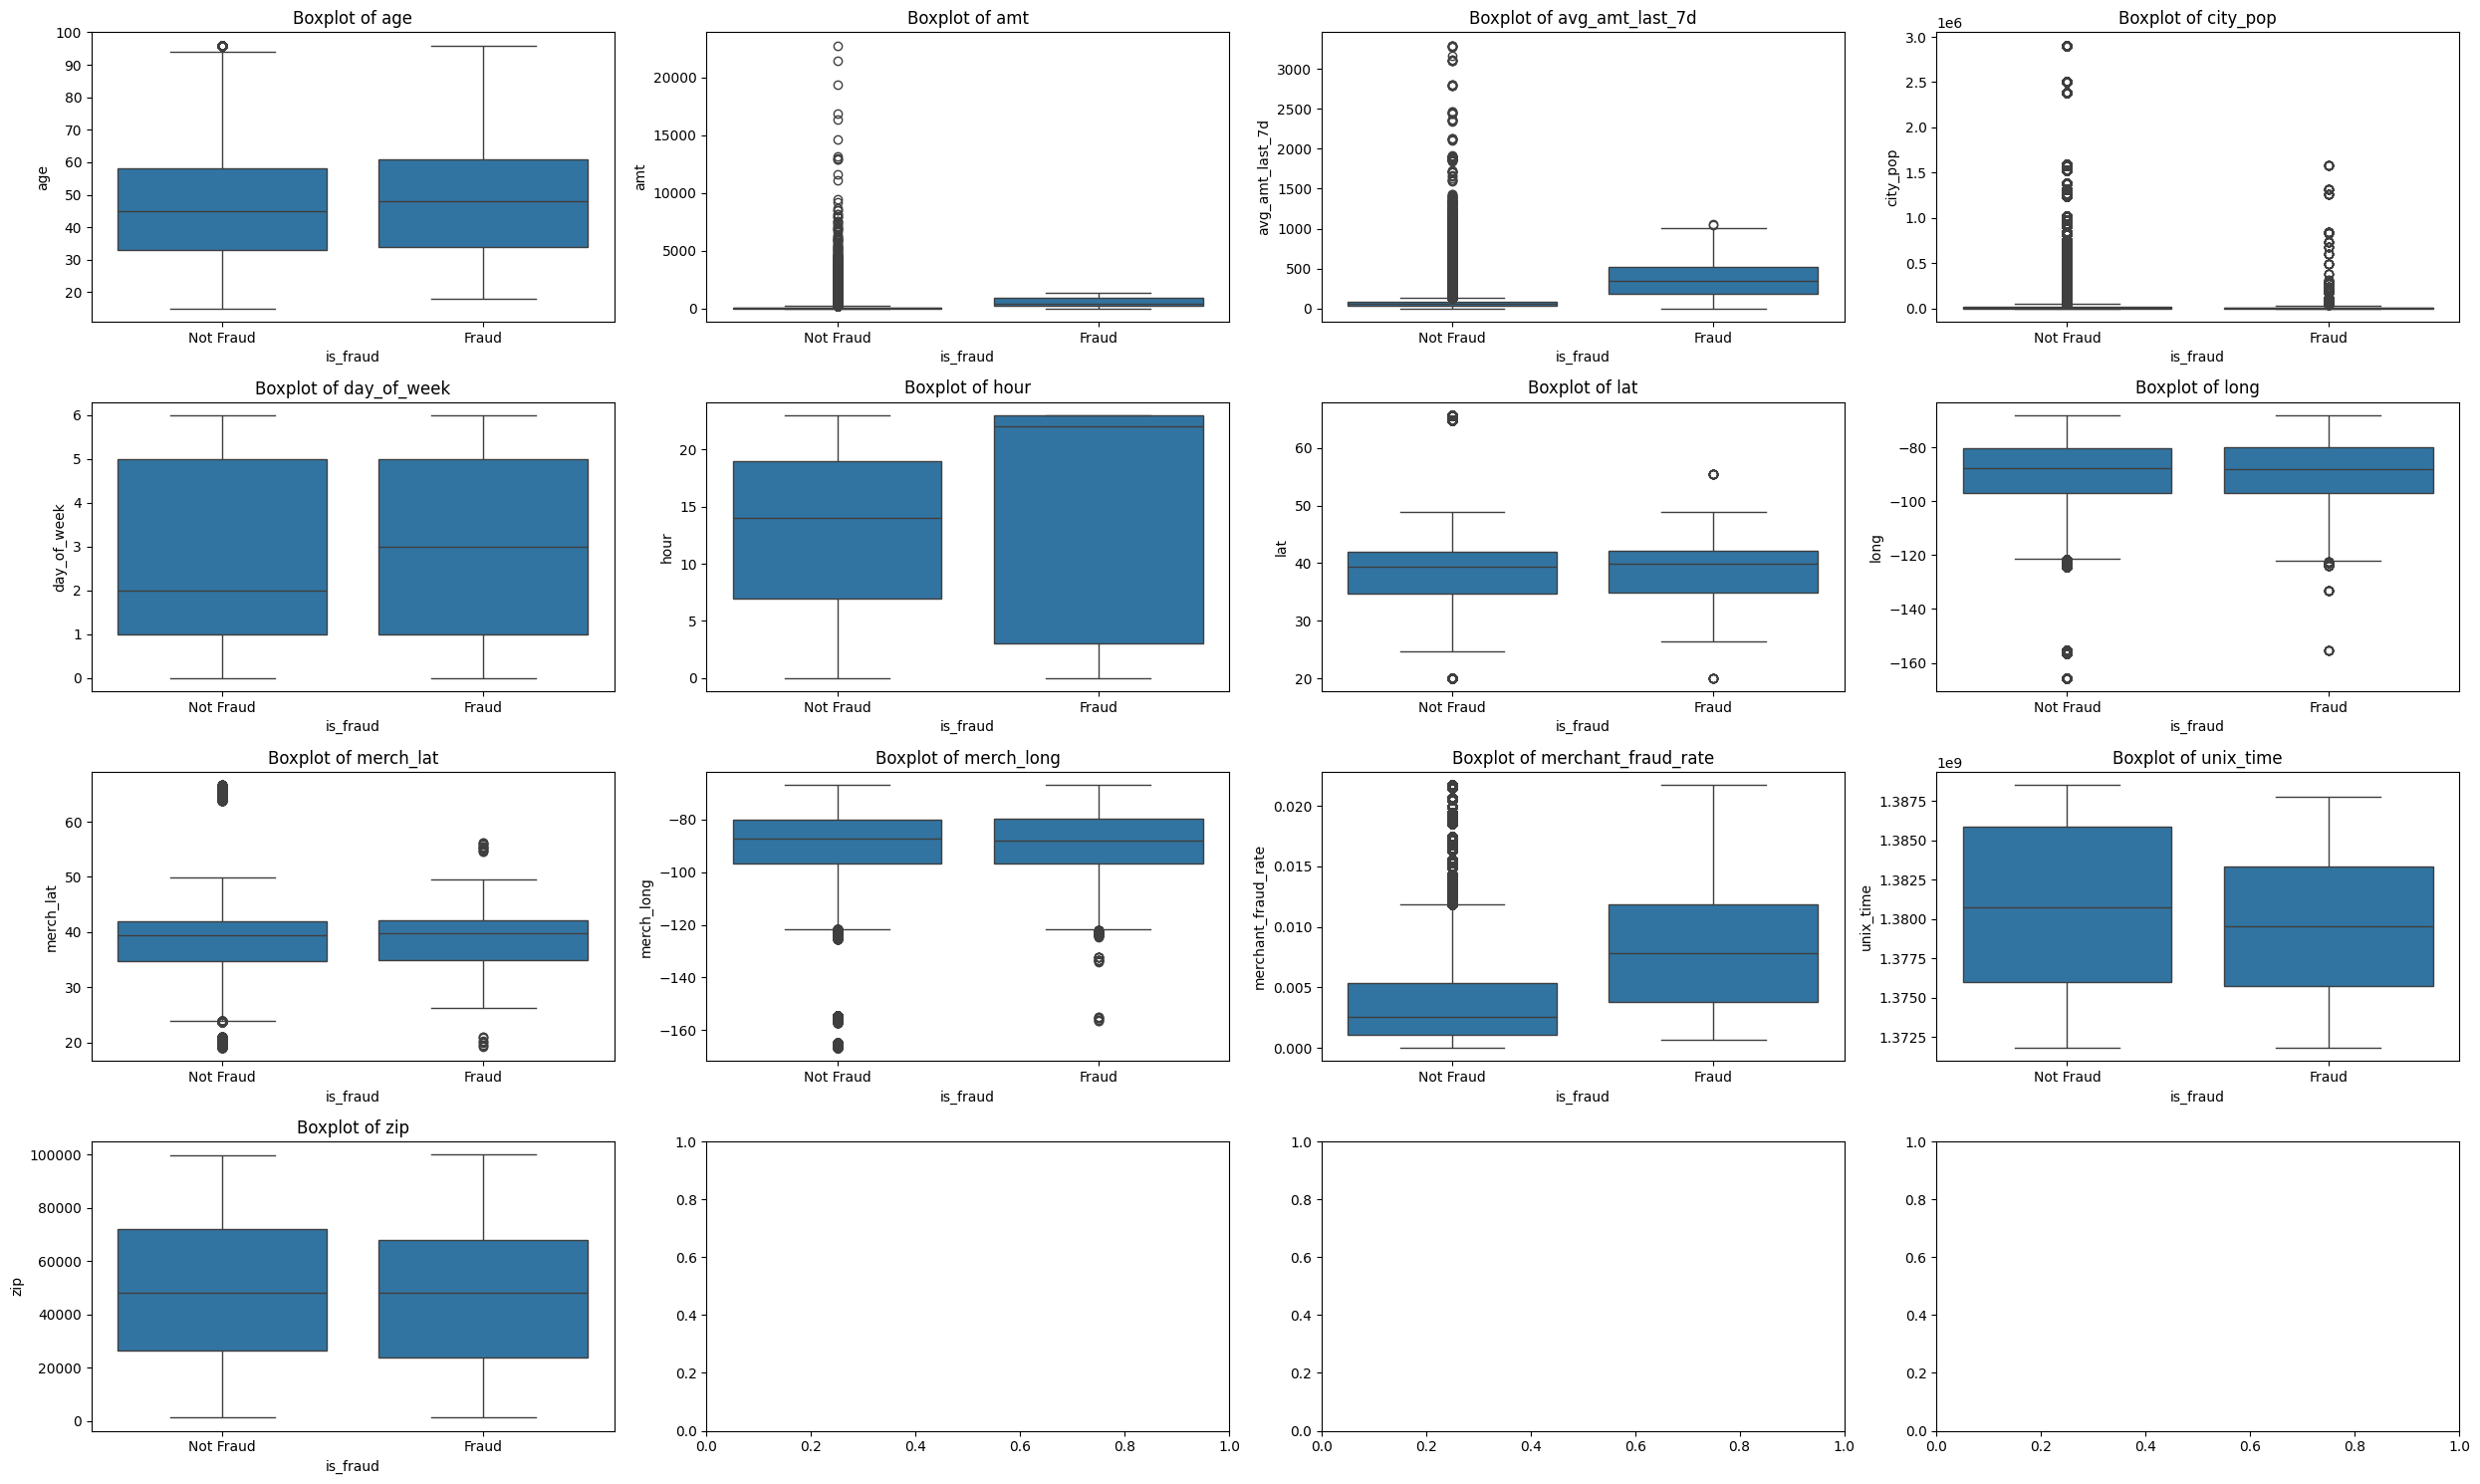

'age' is NOT normally distributed
'amt' is NOT normally distributed
'avg_amt_last_7d' is NOT normally distributed
'city_pop' is NOT normally distributed
'day_of_week' is NOT normally distributed
'hour' is NOT normally distributed
'lat' is NOT normally distributed
'long' is NOT normally distributed
'merch_lat' is NOT normally distributed
'merch_long' is NOT normally distributed
'merchant_fraud_rate' is NOT normally distributed
'unix_time' is NOT normally distributed
'zip' is NOT normally distributed


In [32]:
# Numerical columns
fig, axes = plt.subplots(4, 4, figsize=(25, 15))
axes = axes.flatten()

# Filter numeric columns
plot_cols = num_cols.difference(['is_fraud', 'cc_num'])

# Boxplot
for i, col in enumerate(plot_cols):

  sns.boxplot(data=data, y=col, x='is_fraud', ax=axes[i])
  axes[i].set_title(f"Boxplot of {col}")
  axes[i].set_xticks([0, 1])
  axes[i].set_xticklabels(['Not Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

# Anderson-Darling Test
for col in plot_cols:
  anderson_res = anderson(data[col], dist='norm')

  # Take critical value for 5% significance
  critical_value_5 = anderson_res.critical_values[2]

  # Result
  if anderson_res.statistic > critical_value_5:
      print(f"'{col}' is NOT normally distributed")
  else:
      print(f"'{col}' IS normally distributed")


> **Key Foundings:**
- Contrary with my suspicion, *high amount of transaction doesn't equal to fraud!*
- The median day of the week for fraudulent transactions is around 3 (Thursday). This suggests that fraud tends to occur more frequently toward the end of the week.
- The median transaction hour for fraudulent cases is significantly higher, occurring after hour 20 or 8 PM.

Since none of the numeric columns have a normal distribution and contain outliers, we will use Robust Scaling.

*Note* : outliers are not removed because this dataset deals with fraud detection, where extreme values are highly possible.

In [33]:
for col in cat_cols:
  print(f"\n{col} --------------------")
  print(data[col].value_counts())


merchant --------------------
merchant
fraud_Kilback LLC                        1859
fraud_Cormier LLC                        1597
fraud_Schumm PLC                         1561
fraud_Kuhn LLC                           1521
fraud_Dickinson Ltd                      1519
                                         ... 
fraud_Treutel-King                        323
fraud_Satterfield-Lowe                    319
fraud_Kessler Group                       318
fraud_Jerde-Hermann                       312
fraud_Ritchie, Bradtke and Stiedemann     304
Name: count, Length: 693, dtype: int64

category --------------------
category
gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel            17449
Name: count, dtype: int64

first ------

## Fraud and Non-Fraud Distribution

In [34]:
data['is_fraud'].value_counts()

,count
is_fraud,
0,553574
1,2145


There is a **significant imbalance** between fraud and non-fraud transactions.

## Heatmap

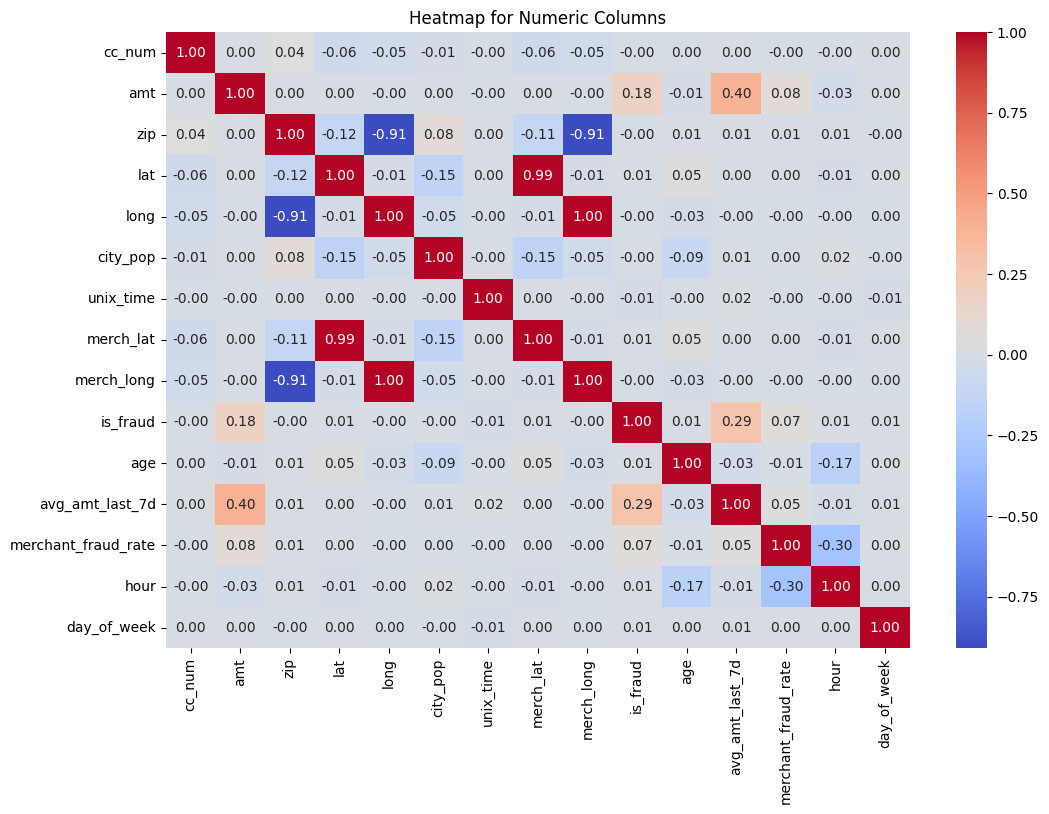

In [35]:
# Heatmap (only numeric columns)
plt.figure(figsize=(12,8))
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap for Numeric Columns")
plt.show()

## Drop Unnecessary Columns

In [36]:
processed_data = data.copy()

In [37]:
processed_data.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,avg_amt_last_7d,merchant_fraud_rate,hour,day_of_week
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,52,0,0.004076,12,6
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,30,0,0.001274,12,6
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,50,0,0.001325,12,6


# Encoding `gender`

In [39]:
# Update categorical and numerical columns
categorical_cols = processed_data.select_dtypes(include = ['object', 'category']).columns
numerical_cols = processed_data.select_dtypes(include = ['number']).columns

print(f'Numerical Columns: {numerical_cols}')
print(f'Categorical Columns: {categorical_cols}')

Numerical Columns: Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'avg_amt_last_7d',
       'merchant_fraud_rate', 'hour', 'day_of_week'],
      dtype='object')
Categorical Columns: Index(['merchant', 'category', 'first', 'last', 'gender', 'street', 'city',
       'state', 'job', 'trans_num'],
      dtype='object')


In [40]:
for col in categorical_cols:
  print(f"\n{col} --------------------")
  print(processed_data[col].value_counts())


merchant --------------------
merchant
fraud_Kilback LLC                        1859
fraud_Cormier LLC                        1597
fraud_Schumm PLC                         1561
fraud_Kuhn LLC                           1521
fraud_Dickinson Ltd                      1519
                                         ... 
fraud_Treutel-King                        323
fraud_Satterfield-Lowe                    319
fraud_Kessler Group                       318
fraud_Jerde-Hermann                       312
fraud_Ritchie, Bradtke and Stiedemann     304
Name: count, Length: 693, dtype: int64

category --------------------
category
gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel            17449
Name: count, dtype: int64

first ------

In [41]:
# 'gender' column
processed_data['gender'] = processed_data['gender'].replace({'M' : 0, 'F' : 1})

/tmp/ipython-input-3761038185.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  processed_data['gender'] = processed_data['gender'].replace({'M' : 0, 'F' : 1})


In [43]:
processed_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,avg_amt_last_7d,merchant_fraud_rate,hour,day_of_week
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,0,351 Darlene Green,Columbia,...,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,52,0,0.004076,12,6
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,1,3638 Marsh Union,Altonah,...,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,30,0,0.001274,12,6
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,1,9333 Valentine Point,Bellmore,...,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,50,0,0.001325,12,6
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,0,32941 Krystal Mill Apt. 552,Titusville,...,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,33,0,0.004219,12,6
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,0,5783 Evan Roads Apt. 465,Falmouth,...,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,65,0,0.002703,12,6


# Data Splitting

In [45]:
y = processed_data['is_fraud']
X = processed_data.drop(['is_fraud'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"X_val : {X_val.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")
print(f"y_val : {y_val.shape}")

X_train : (355660, 26)
X_test : (111144, 26)
X_val : (88915, 26)
y_train : (355660,)
y_test : (111144,)
y_val : (88915,)


In [46]:
X_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'age', 'avg_amt_last_7d', 'merchant_fraud_rate', 'hour',
       'day_of_week'],
      dtype='object')

In [47]:
X_test.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'age', 'avg_amt_last_7d', 'merchant_fraud_rate', 'hour',
       'day_of_week'],
      dtype='object')

# Pipeline

In [48]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [49]:
# Numerical feature to scale
numeric_features = ['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'avg_amt_last_7d', 'merchant_fraud_rate',
                    'hour', 'day_of_week', 'gender']

# OneHotEncode
categorical_features = ['category']

# Drop features
drop_features = ['cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state',
                 'dob', 'trans_num', 'trans_date_trans_time', 'unix_time', 'job']

## Processor

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('drop', 'drop', drop_features)
    ],
    remainder='passthrough'
)

In [52]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', RobustScaler(),
                                 ['amt', 'zip', 'lat', 'long', 'city_pop',
                                  'merch_lat', 'merch_long', 'age',
                                  'avg_amt_last_7d', 'merchant_fraud_rate',
                                  'hour', 'day_of_week', 'gender']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['category']),
                                ('drop', 'drop',
                                 ['cc_num', 'merchant', 'first', 'last',
                                  'street', 'city', 'state', 'dob', 'trans_num',
                                  'trans_date_trans_time', 'unix_time',
                                  'job'])])

# Model (with SHAP)


## Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
rf_model = RandomForestClassifier(random_state=SEED)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf_model)])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['amt', 'zip', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'age',
                                                   'avg_amt_last_7d',
                                                   'merchant_fraud_rate',
                                                   'hour', 'day_of_week',
                                                   'gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('drop', 'drop',
                                                  ['cc_num', 'merchant',
                                                   'first', 'last', 'street',
                                                   'city', 'state', 'dob',
                                                   'trans_num',
                                                   'trans_date_trans_time',
                                                   'unix_time', 'job'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355660 entries, 358739 to 120470
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  355660 non-null  datetime64[ns]
 1   cc_num                 355660 non-null  int64         
 2   merchant               355660 non-null  object        
 3   category               355660 non-null  object        
 4   amt                    355660 non-null  float64       
 5   first                  355660 non-null  object        
 6   last                   355660 non-null  object        
 7   gender                 355660 non-null  int64         
 8   street                 355660 non-null  object        
 9   city                   355660 non-null  object        
 10  state                  355660 non-null  object        
 11  zip                    355660 non-null  int64         
 12  lat                    355660 non-null  floa

In [59]:
X_val_sample = shap.utils.sample(X_val, 100)  # take 100 sample from X_val

In [60]:
# SHAP RF

X_train_rf = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_val_rf = rf_pipeline.named_steps['preprocessor'].transform(X_val_sample)

feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer_rf = shap.Explainer(rf_pipeline.named_steps['classifier'], X_train_rf)

X_val_rf = pd.DataFrame(X_val_rf, columns=feature_names)

# SHAP values
shap_values_rf = explainer_rf(X_val_rf)

In [61]:
type(shap_values_rf)

shap._explanation.Explanation

In [62]:
shap_values_rf.shape # (100, 27, 2) means 100 data, 27 column, 2 class

(100, 27, 2)

/tmp/ipython-input-1866773531.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, 1], X_val_rf, plot_type='bar')


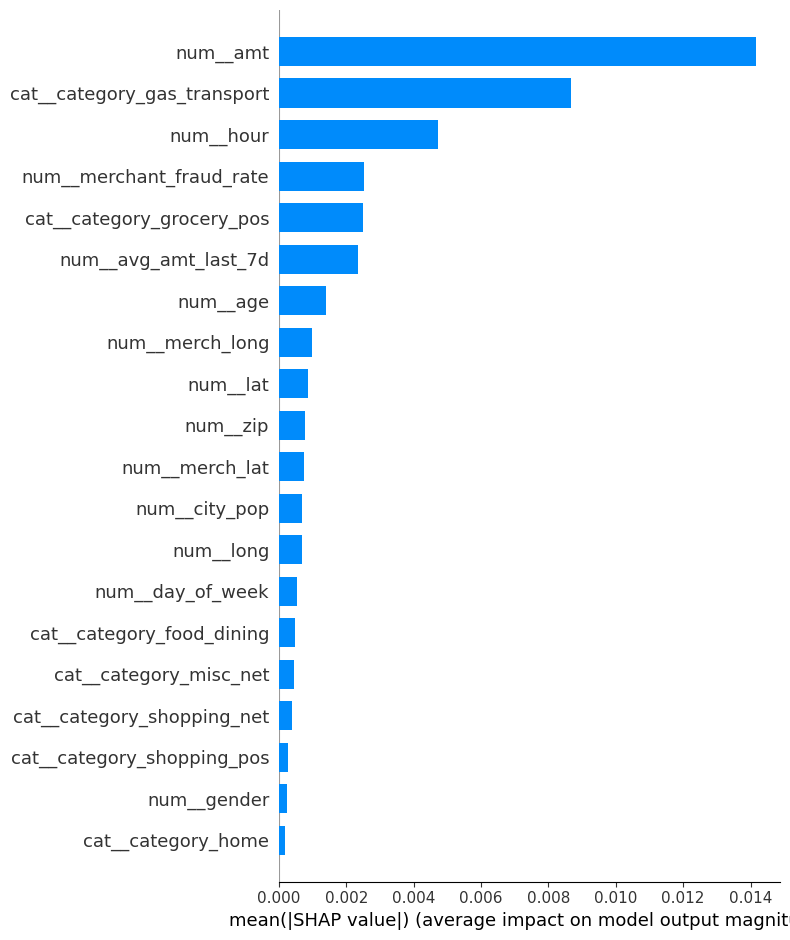

In [63]:
shap.summary_plot(shap_values_rf[:, :, 1], X_val_rf, plot_type='bar')

The SHAP summary plot indicates that `amt` (transaction amount),  `category_gas_transport`, and `hour` have the highest mean SHAP values, meaning they contribute the most to the model's fraud prediction decisions. Features like `avg_amt_last_7d`, `category_grocery_pos`, and `merchant_fraud_rate` also show notable impact, highlighting the importance of recent transaction behavior and merchant reputation. Overall, the model relies most on transaction value, category, and behavioral patterns to detect fraud.


In [64]:
X_val_sample.shape

(100, 26)

In [65]:
type(shap_values_rf)

shap._explanation.Explanation

In [66]:
# for beeswarm and waterfall
shap_values_rf_class1 = shap.Explanation(
    values = shap_values_rf.values[:, :, 1],
    base_values = shap_values_rf.base_values[:, 1],
    data = shap_values_rf.data,
    feature_names = shap_values_rf.feature_names
)

Summary plot can directly `use shap_values_rf[:, :, 1]`. But for beeswarm and waterfall, we need to manually extract class 1 values using `shap.Explanation()`.

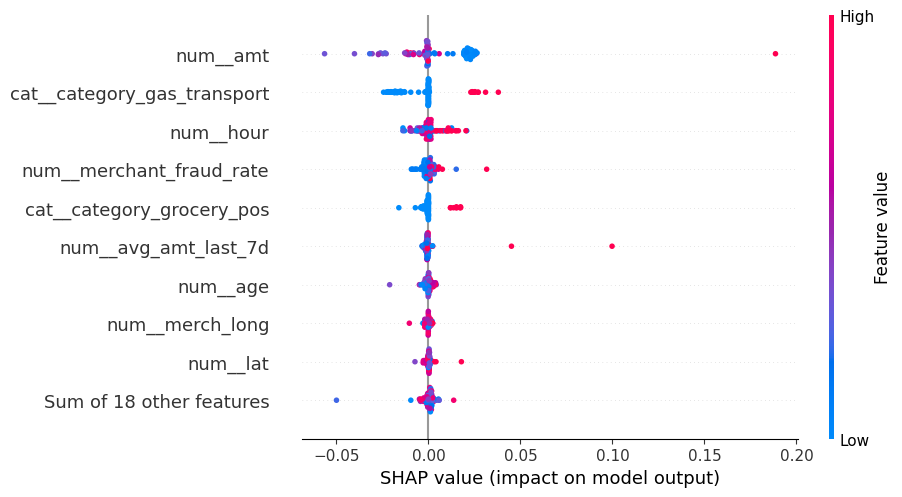

In [67]:
shap.plots.beeswarm(shap_values_rf_class1)

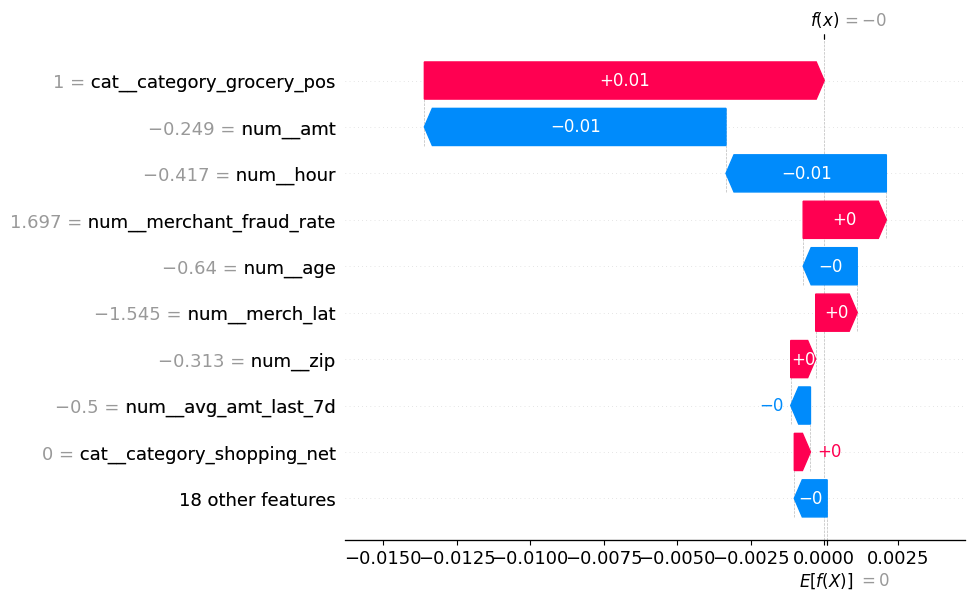

In [68]:
shap.plots.waterfall(shap_values_rf_class1[1]) # class 1

In [69]:
y_pred_rf = rf_pipeline.predict(X_test)

In [70]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f'Classification Report:\n{classification_report(y_test, y_pred_rf)}')

Confusion Matrix:
 [[110714      4]
 [   106    320]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.99      0.75      0.85       426

    accuracy                           1.00    111144
   macro avg       0.99      0.88      0.93    111144
weighted avg       1.00      1.00      1.00    111144



## XGBoost

In [71]:
!pip install xgboost==2.1.4

In [72]:
from xgboost import XGBClassifier
import xgboost as xgb

In [73]:
print(xgb.__version__)

2.1.4


In [74]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=SEED
)

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', xgb_model)])

xgb_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['amt', 'zip', 'lat', 'long',
                                                   'city_pop', 'merch_lat',
                                                   'merch_long', 'age',
                                                   'avg_amt_last_7d',
                                                   'merchant_fraud_rate',
                                                   'hour', 'day_of_week',
                                                   'gender']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category']),
                                                 ('drop', 'drop',
                                                  ['cc_num', 'merchant',
                                                   'fir...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [75]:
# SHAP XGBOOST

X_train_xgb = xgb_pipeline.named_steps['preprocessor'].transform(X_train)
X_val_xgb = xgb_pipeline.named_steps['preprocessor'].transform(X_val_sample)

feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

explainer_xgb = shap.Explainer(xgb_pipeline.named_steps['classifier'], X_train_xgb)

X_val_xgb = pd.DataFrame(X_val_xgb, columns=feature_names)

# SHAP values
shap_values_xgb = explainer_xgb(X_val_xgb)

In [76]:
type(shap_values_xgb)

shap._explanation.Explanation

In [77]:
shap_values_xgb.shape

(100, 27)

/tmp/ipython-input-3920489572.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_val_xgb, plot_type='bar')


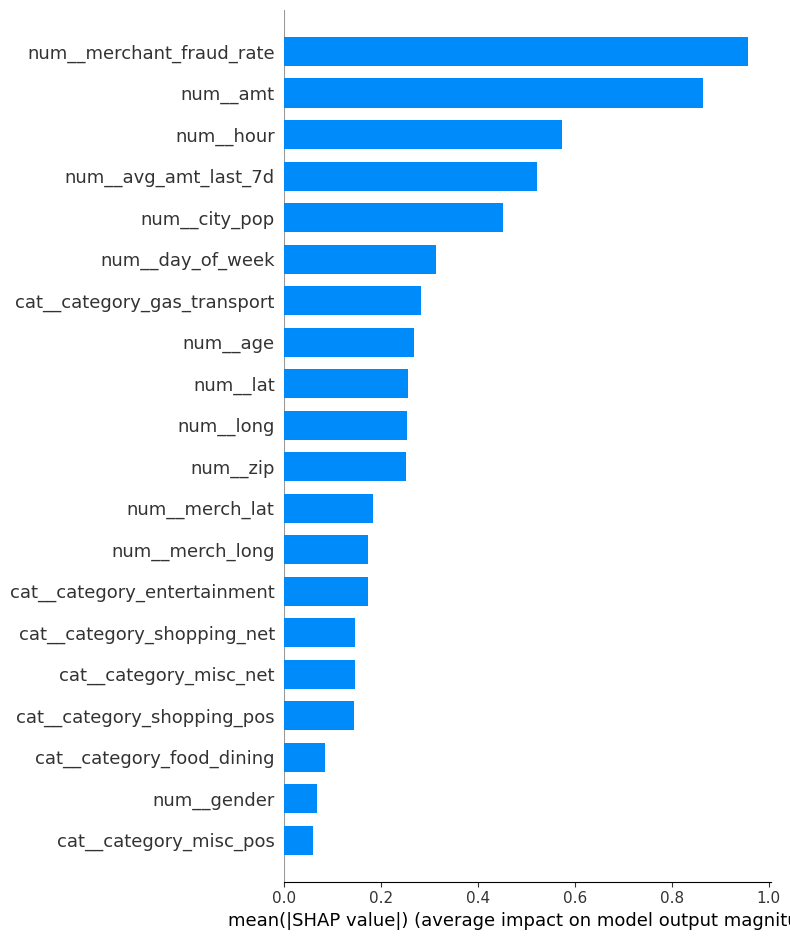

In [78]:
shap.summary_plot(shap_values_xgb, X_val_xgb, plot_type='bar')

The XGBoost SHAP summary plot shows that `merchant_fraud_rate`, `amt`, and `hour` are the most influential features, exhibiting the highest mean SHAP values. Meanwhile, `avg_amt_last_7d`, `city_pop`, and `day_of_week` indicates a mid-level impact on the model's predictions.

In [79]:
y_pred_xgb = xgb_pipeline.predict(X_test)

In [80]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(f'Classification Report:\n{classification_report(y_test, y_pred_xgb)}')

Confusion Matrix:
 [[110703     15]
 [    63    363]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.96      0.85      0.90       426

    accuracy                           1.00    111144
   macro avg       0.98      0.93      0.95    111144
weighted avg       1.00      1.00      1.00    111144



## ANN

In [81]:
!pip install scikeras

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.base import BaseEstimator

In [83]:
def create_ann_model(meta):
    # meta-parameter will automatically filled by scikeras
    n_features_in_ = meta["n_features_in_"]
    model = Sequential([
        Dense(64, activation='relu', input_shape=(n_features_in_,)),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ann_model = KerasClassifier(
    model=create_ann_model,
    verbose=1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

In [85]:
ann_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ann_model)
])


ann_pipeline.fit(X_train, y_train
                 , classifier__validation_data=(preprocessor.transform(X_val), y_val))

print("...ANN fit, done!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9965 - loss: 0.0231 - val_accuracy: 0.9979 - val_loss: 0.0090
Epoch 2/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9983 - val_loss: 0.0066
Epoch 3/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9985 - val_loss: 0.0061
Epoch 4/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9984 - loss: 0.0060 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 5/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9986 - loss: 0.0056 - val_accuracy: 0.9985 - val_loss: 0.0057
Epoch 6/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 7/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9986 - val_loss: 0.0050
Epoch 8/10
11115/11115 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 

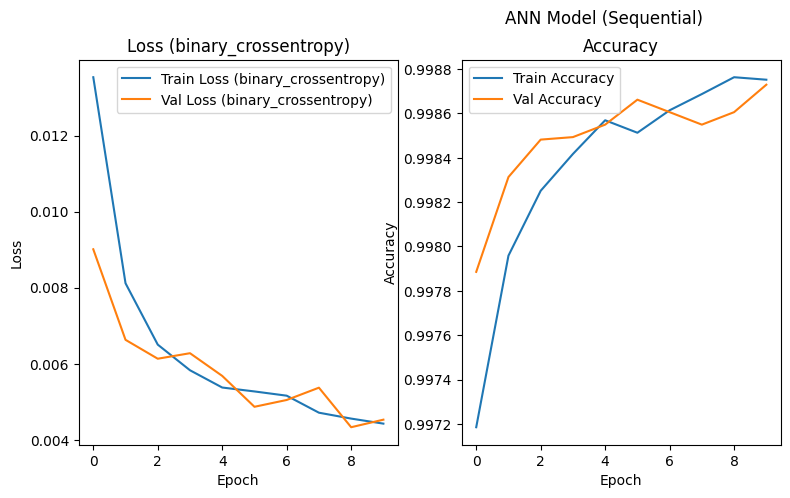

In [86]:
# Plot
history = ann_pipeline.named_steps['classifier'].model_.history.history

plt.figure(figsize=(14, 5))
plt.suptitle('ANN Model (Sequential)')

# Loss (binary_crossentropy)
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Train Loss (binary_crossentropy)')
plt.plot(history['val_loss'], label='Val Loss (binary_crossentropy)')
plt.title('Loss (binary_crossentropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

The plot shows a slight underfitting as the training and validation metrics are closely aligned throughout the epochs. There are no signs of overfitting, which indicates the model **generalizes well** to unseen data.

In [95]:
# SHAP ANN
X_train_ann = ann_pipeline.named_steps['preprocessor'].transform(X_train)
X_val_ann = ann_pipeline.named_steps['preprocessor'].transform(X_val_sample)

feature_names = ann_pipeline.named_steps['preprocessor'].get_feature_names_out()

background = X_train_ann[:500] if X_train_ann.shape[0] > 500 else X_train_ann

model_keras = ann_pipeline.named_steps['classifier'].model_ # take keras model from scikeras wrapper

explainer_ann = shap.Explainer(model_keras, background)

# X_val_ann = pd.DataFrame(X_val_ann, columns=feature_names)

# SHAP values
shap_values_ann = explainer_ann(X_val_ann)

PermutationExplainer explainer: 101it [00:15,  3.96it/s]                         


In [96]:
shap_values_ann.shape

(100, 27)

/tmp/ipython-input-997605545.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ann, X_val_ann, feature_names=feature_names, plot_type='bar')


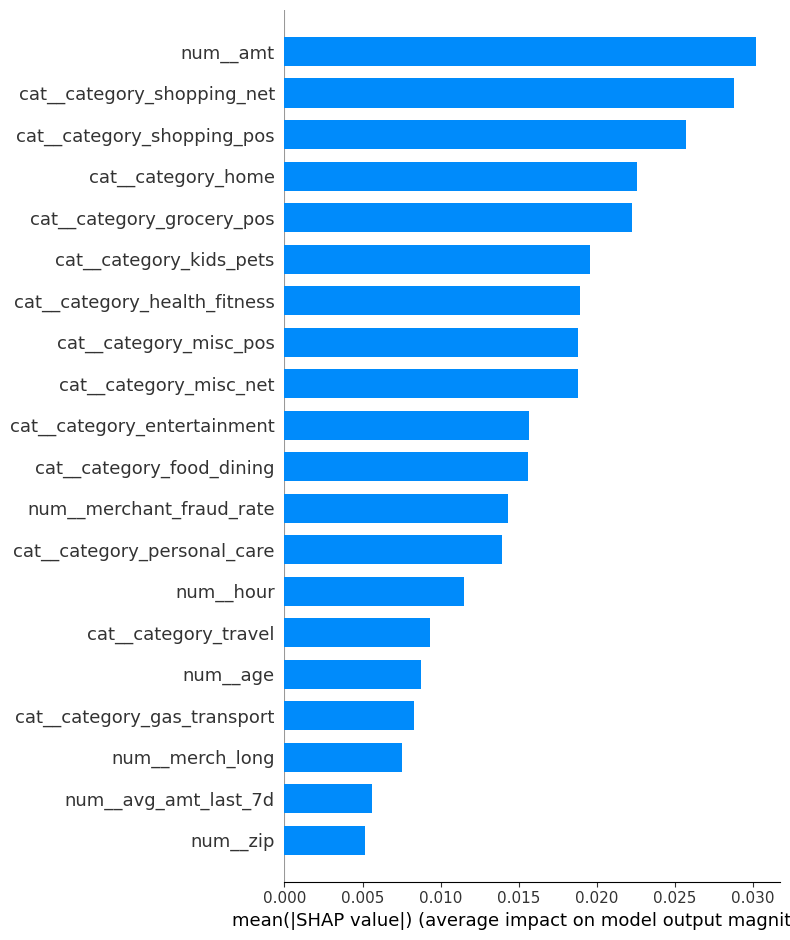

In [98]:
shap.summary_plot(shap_values_ann, X_val_ann, feature_names=feature_names, plot_type='bar')

The ANN SHAP summary plot reveals that the model relies heavily on `amt` and merchant categories.

In [103]:
X_test_ann = ann_pipeline.named_steps['preprocessor'].transform(X_test)

# predict probability
y_pred_ann_prob = model_keras.predict(X_test_ann)

# change to 0/1 (threshold 0.5)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int)

3474/3474 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [104]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print(f'Classification Report:\n{classification_report(y_test, y_pred_ann)}')

Confusion Matrix:
 [[110692     26]
 [    91    335]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.93      0.79      0.85       426

    accuracy                           1.00    111144
   macro avg       0.96      0.89      0.93    111144
weighted avg       1.00      1.00      1.00    111144



## Comparison

In [105]:
print("Random Forest ----------")
print(classification_report(y_test, y_pred_rf))

print("XGBoost ----------")
print(classification_report(y_test, y_pred_xgb))

print("ANN ----------")
print(classification_report(y_test, y_pred_ann))

Random Forest ----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.99      0.75      0.85       426

    accuracy                           1.00    111144
   macro avg       0.99      0.88      0.93    111144
weighted avg       1.00      1.00      1.00    111144

XGBoost ----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.96      0.85      0.90       426

    accuracy                           1.00    111144
   macro avg       0.98      0.93      0.95    111144
weighted avg       1.00      1.00      1.00    111144

ANN ----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.93      0.79      0.85       426

    accuracy                           1.00    111144
   macro avg       0.96      0.89      0.93    111144
weighted avg   

To predict fraud and reduce chargebacks, **recall** (particularly for class 1) is the most important metric. A higher recall helps minimize false negatives, where fraudulent transactions are mistakenly predicted as legitimate, which can lead to costly chargebacks.

In this project, the ***XGBoost model*** achieved the highest recall score for the fraud class, making it the best model for detecting as many fraudulent transactions as possible and minimizing financial losses from chargebacks.

# Save as Pickle Model

In [106]:
import pickle

In [107]:
with open('fraud_pipeline.pkl', 'wb') as file:
    pickle.dump(xgb_pipeline, file)

In [108]:
import os
print(f"Model size: {os.path.getsize('fraud_pipeline.pkl') / (1024*1024):.2f} MB")

Model size: 0.26 MB
